Mounted at /content/drive
      Dependency Ratio  Self-sufficiency Score
Year                                          
2000          0.608393                0.391607
2001          0.622892                0.377108
2002          0.624169                0.375831
2003          0.649732                0.350268
2004          0.675697                0.324303
2005          0.691802                0.308198
2006          0.683982                0.316018
2007          0.678585                0.321415
2008          0.684315                0.315685
2009          0.647417                0.352583
2010          0.639682                0.375612
2011          0.638717                0.410926
2012          0.617790                0.445378
2013          0.543467                0.516885
2014          0.501122                0.562884
2015          0.491004                0.577671
2016          0.530339                0.549125
2017          0.526609                0.571428
2018          0.515944            

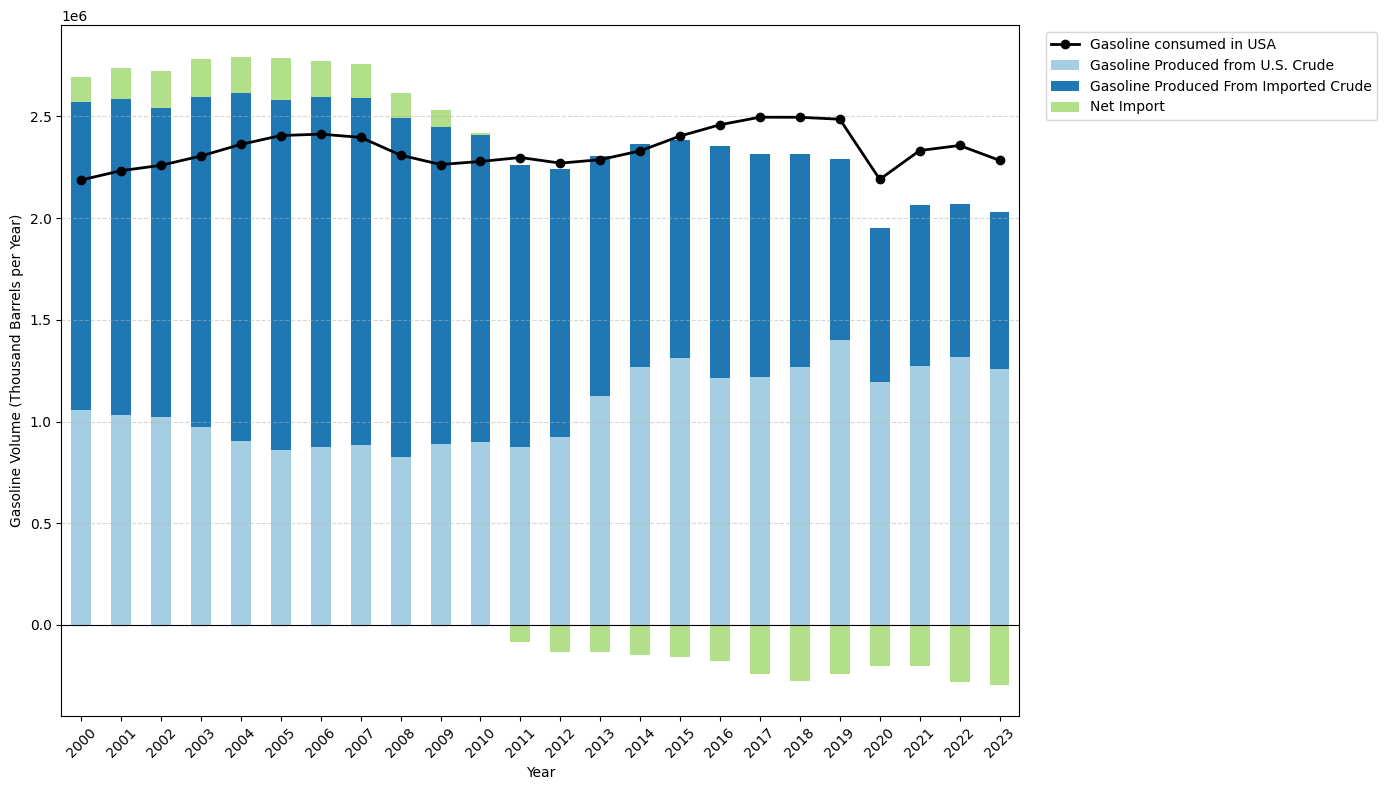

In [1]:
# ========== Step 0: Mount Google Drive ==========
from google.colab import drive
drive.mount('/content/drive')

# ========== Step 1: Import packages ==========
import pandas as pd
import matplotlib.pyplot as plt

# ========== Step 2: Load and preprocess ==========
file_path = "/content/drive/My Drive/datathon 2025/weekly_supply_estimates.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# ========== Step 3: Aggregate yearly ==========
total_crude_input = df.groupby('Year')[
    'Weekly U.S. Refiner Net Input of Crude Oil  (Thousand Barrels per Day)'
].mean() * 365

imported_crude = df.groupby('Year')[
    'Weekly U.S. Imports of Crude Oil  (Thousand Barrels per Day)'
].mean() * 365

us_crude = total_crude_input - imported_crude
crude_to_gas_yield = 0.466
gasoline_from_us_crude = us_crude * crude_to_gas_yield
gasoline_from_imported_crude = imported_crude * crude_to_gas_yield

gasoline_import = df.groupby('Year')[
    'Weekly U.S. Imports of Finished Motor Gasoline  (Thousand Barrels per Day)'
].mean() * 365

gasoline_export = df.groupby('Year')[
    'Weekly U.S. Exports of Total Motor Gasoline (Thousand Barrels per Day)'
].mean() * 365

# ========== Step 4: Build stacked data ==========
common_years = gasoline_from_us_crude.index.intersection(
    gasoline_from_imported_crude.index
).intersection(gasoline_import.index).intersection(gasoline_export.index)

df_stacked = pd.DataFrame({
    'Gasoline Produced from U.S. Crude': gasoline_from_us_crude.loc[common_years],
    'Gasoline Produced From Imported Crude': gasoline_from_imported_crude.loc[common_years],
    'Net Import': gasoline_import.loc[common_years]
})

# ========== Step 5: Calculate positive and negative parts ==========
df_positive = df_stacked.subtract(gasoline_export.loc[common_years], axis=0).clip(lower=0)
df_negative = df_stacked.subtract(gasoline_export.loc[common_years], axis=0).clip(upper=0)

# ========== Step 6: EIA Official demand (rescaled) ==========
eia_product_supplied = pd.Series({
    2000: 312520, 2001: 319057, 2002: 322801, 2003: 329369,
    2004: 337512, 2005: 343735, 2006: 344692, 2007: 342417,
    2008: 329953, 2009: 323365, 2010: 325515, 2011: 328288,
    2012: 324338, 2013: 326778, 2014: 332950, 2015: 343378,
    2016: 351303, 2017: 356604, 2018: 356542, 2019: 355174,
    2020: 312940, 2021: 333178, 2022: 336757, 2023: 326300
})

our_supply = df_stacked.subtract(gasoline_export.loc[common_years], axis=0).sum(axis=1)
overlap_years = our_supply.index.intersection(eia_product_supplied.index)
scaling_ratio = (our_supply.loc[overlap_years] / eia_product_supplied.loc[overlap_years]).mean()
final_demand_line = eia_product_supplied.loc[df_stacked.index] * scaling_ratio

# ========== Step 6.1: Calculate Dependency Ratio and Self-sufficiency ==========
total_supply = gasoline_from_us_crude + gasoline_from_imported_crude + gasoline_import
net_supply = total_supply - gasoline_export.loc[common_years]

dependency_ratio = (gasoline_from_imported_crude + gasoline_import) / net_supply
self_sufficiency = gasoline_from_us_crude / net_supply

df_dependency = pd.DataFrame({
    "Dependency Ratio": dependency_ratio,
    "Self-sufficiency Score": self_sufficiency
})
print(df_dependency)


# ========== Step 7: Plot ==========
fig, ax = plt.subplots(figsize=(14, 8))

df_positive.plot(kind='bar', stacked=True, ax=ax,
                 color=["#a6cee3", "#1f78b4", "#b2df8a"])

df_negative.plot(kind='bar', stacked=True, ax=ax,
                 color=["#a6cee3", "#1f78b4", "#b2df8a"], legend=False)

ax.plot(
    range(len(final_demand_line)),
    final_demand_line.values,
    color='black',
    marker='o',
    linewidth=2,
    label='Gasoline consumed in USA',
    zorder=10
)

handles, labels = ax.get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
ax.legend(unique.values(), unique.keys(),
          loc='upper left', bbox_to_anchor=(1.02, 1))

# ========== Step 8: Format ==========
ax.set_ylabel("Gasoline Volume (Thousand Barrels per Year)")
ax.set_xlabel("Year")
ax.set_xticks(range(len(df_positive.index)))
ax.set_xticklabels(df_positive.index, rotation=45)
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
